### Search using facebook FAISS
[faiss](https://github.com/facebookresearch/faiss)

In [11]:
import json
# Used to import data from S3.
import pandas as pd

# Used to create the dense document vectors.
import torch
from sentence_transformers import SentenceTransformer

# Used to create and store the Faiss index.
import faiss
import numpy as np
import pickle

# Used to do vector searches and display the results.
#from vector_engine.utils import vector_search, id2details

### Import
Import the file exported from the excel file

In [3]:
with open('D:/1. Papers/4. MyPapers/6_(20210609) Skill taxonomy/primitiveDef.json') as json_file:
    primitiveDef = json.load(json_file)

#print(primitiveDef)

# Preprocessing
Follow guide from: https://www.pinecone.io/learn/faiss-tutorial/

In [4]:
# remove duplicates
primitiveDefSing = [word for word in list(set(primitiveDef)) if type(word) is str]

In [6]:
from sentence_transformers import SentenceTransformer
# initialize sentence transformer model
model = SentenceTransformer('bert-base-nli-mean-tokens')
# create sentence embeddings
sentence_embeddings = model.encode(primitiveDefSing)
sentence_embeddings.shape

(148, 768)

In [52]:
import faiss

d = sentence_embeddings.shape[1]
index = faiss.IndexFlatL2(d)
index.is_trained
index.add(sentence_embeddings)
index.ntotal

148

How to simply search with faiss using the IndexFlat2 index created above. We must provide query here

In [42]:
k = 2
xq = model.encode(["unscrew"])

D, I = index.search(xq, k)  # search

[ 83 121]
displace
screw a nut


Knowing that the KNN can return two clusters now I will loop through them ot find common clusters

<!-- for primitive in primitiveDefSing:
    print(primitive)
    k = 2
    xq = model.encode([str(primitive)])

    D, I = index.search(xq, k)  # search
    print(I)
    print(D) -->

Here he use the clustering provided in the [faiss-wiki](https://github.com/facebookresearch/faiss/wiki/Faiss-building-blocks:-clustering,-PCA,-quantization)

In [88]:
d = sentence_embeddings.shape[1]
index = faiss.IndexFlatL2(d)
index.is_trained
index.add(sentence_embeddings)
index.ntotal
ncentroids = 10
niter = 20
verbose = True
kmeans = faiss.Kmeans(d, ncentroids, niter=niter, verbose=verbose)
kmeans.train(sentence_embeddings)
print(len(kmeans.centroids))

10


In [131]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)

principalComponents = pca.fit_transform(sentence_embeddings)

#print(principalComponents[:,1])
x = principalComponents[:,0].tolist()
y = principalComponents[:,1].tolist()

               primitive  cluster    distance         x         y
0         motion control        4   67.627655 -1.585058  0.238374
1     dynamic movemement        4   78.057892 -1.549468  0.515662
2                 search        1   61.370728 -1.749492 -1.416194
3                    put        1   22.141968 -3.563525 -2.408525
4  start tool with x rpm        6  118.899963  1.151923  6.209590


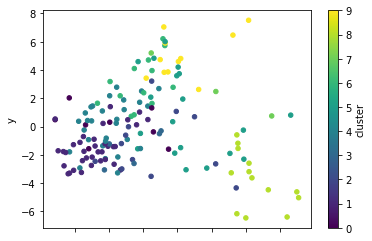

In [136]:
D, I = kmeans.index.search(sentence_embeddings, 1)
#print(D[:,0])
Ilist = I[:,0].tolist()
Dlist = D[:,0].tolist()
#print(Ilist)
d = {'primitive':primitiveDefSing, 'cluster':Ilist, 'distance':Dlist, 'x':x, 'y': y}
#print(d)

cluster = pd.DataFrame(d)
print(cluster.head())

ax1 = cluster.plot.scatter(x='x', y='y', c='cluster', colormap='viridis')